In [7]:
import torch
import torchvision.models as models
import torch.nn as nn
from voc12 import my_dataloader
import os
from utility.image_util import *
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import importlib

In [8]:
img_name_list = "voc12/val.txt"
voc12_root = "../Dataset/VOC2012/"

model = getattr(importlib.import_module("net.resnet38d"), 'Net')()
model.train() 



In [5]:
dataset = my_dataloader.VOC12ImageDataset(img_name_list, voc12_root)

data_loader = DataLoader(dataset)

In [18]:
data = next(iter(data_loader))

img = data['img']
N, C, H, W = img.size()
d = model.forward_as_dict(img)
fc8 = nn.Conv2d(4096, 21, 1, bias = False)
dropout = nn.Dropout2d(0.5)

cam = fc8(dropout(d['conv6']))
n,c,h,w = cam.size()
cam_d = F.relu(cam.detach())
cam_d_max = torch.max(cam_d.view(n,c,-1), dim=-1)[0].view(n,c,1,1)+1e-5
cam_d_norm = F.relu(cam_d-1e-5)/cam_d_max
cam_d_norm[:,0,:,:] = 1-torch.max(cam_d_norm[:,1:,:,:], dim=1)[0]
cam_max = torch.max(cam_d_norm[:,1:,:,:], dim=1, keepdim=True)[0]
cam_d_norm[:,1:,:,:][cam_d_norm[:,1:,:,:] < cam_max] = 0



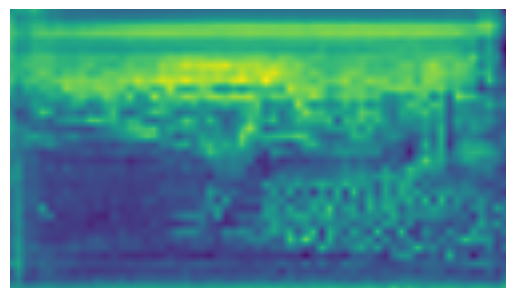

In [26]:
cam = F.interpolate(cam, (H,W), mode = 'bilinear', align_corners=True)

image_show(cam[0][4].detach())